In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import scipy
import matplotlib.image as mpimg
import matplotlib.patches as patches

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Load NIH data
data_dir = "C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive"
all_xray_df = pd.read_csv(f"{data_dir}/Data_Entry_2017.csv")

# Fix columns and column names
all_xray_df.drop(columns=['Unnamed: 11'], inplace=True)
all_xray_df.rename(columns={'OriginalImage[Width': 'OriginalImageWidth', 'Height]': 'OriginalImageHeight', 'OriginalImagePixelSpacing[x': 'OriginalImagePixelSpacing_x', 'y]': 'OriginalImagePixelSpacing_y'}, inplace=True)

# Add path column to make retrieval easier
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(data_dir,'images*', '*', '*.png'))}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Display a few rows
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
71882,00017714_002.png,Infiltration,2,17714,19,M,AP,3056,2544,0.139,0.139,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...
59134,00014626_030.png,No Finding,30,14626,44,F,AP,3056,2544,0.139,0.139,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...
86636,00021374_013.png,Atelectasis|Emphysema|Infiltration|Pneumothorax,13,21374,80,M,AP,3056,2544,0.139,0.139,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...


In [3]:
# Load bounding box data
bbox_df = pd.read_csv(f"{data_dir}/BBox_List_2017.csv")

# Fix columns and column names
bbox_df.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True)
bbox_df.rename(columns={'Bbox [x': 'Bbox_x', 'y': 'Bbox_y', 'w': 'Bbox_w', 'h]': 'Bbox_h'}, inplace=True)

# Display a few rows
bbox_df.sample(3)

,Image Index,Finding Label,Bbox_x,Bbox_y,Bbox_w,Bbox_h
183,00019426_000.png,Cardiomegaly,448.542373,441.220339,395.932203,272.271186
976,00001320_003.png,Atelectasis,208.042674,545.185191,72.817778,29.582222
628,00003440_000.png,Mass,591.644444,457.278307,114.861376,113.777778


In [4]:
data_sample = pd.read_csv('sample_labels.csv')

# Add path column to make retrieval easier
data_sample['path'] = data_sample['Image Index'].map(all_image_paths.get)

data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
584,00003028_051.png,Infiltration,51,3028,058Y,F,AP,2500,2048,0.168,0.168,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...
2541,00012782_001.png,No Finding,1,12782,025Y,F,PA,2682,2793,0.143,0.143,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...
1046,00005460_000.png,No Finding,0,5460,033Y,M,PA,2500,2048,0.171,0.171,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...


In [5]:
# 1. Create distributions of diseases and comorbidities in the dataset

# Split the diseases and comorbidities by the "Finding Labels" column, in order to have one column per disease as a binary value
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

# Add a binary value for each disease
all_xray_df['FindingLabels_Original'] = all_xray_df['Finding Labels']
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# Display a few rows
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Check the number of unique labels
len(all_labels)

15

In [7]:
# Check the distribution of diseases and comorbidities
all_xray_df[all_labels].sum() / len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

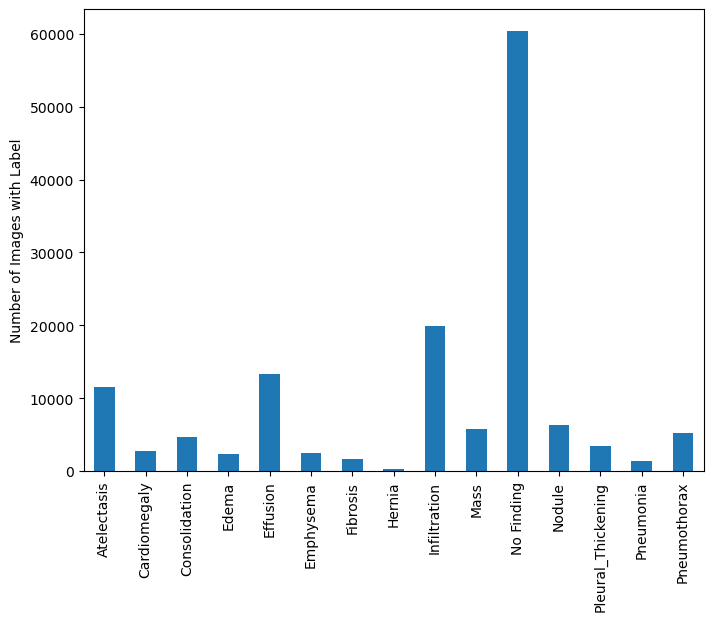

In [8]:
# Plot the frequency of each disease
plt.figure(figsize=(8,6))
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label');

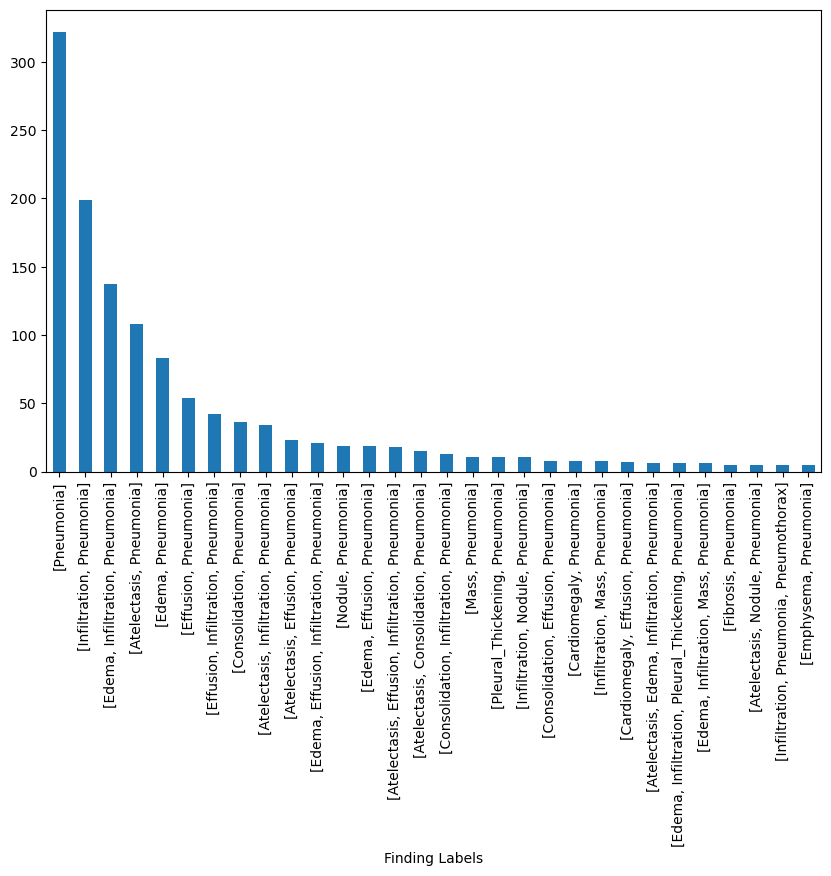

In [9]:
# Check Pneumonia cases and their distribution
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar');

# From this plot, we can see that Pneumonia most often has comorbidity with Infiltration
# Followed by:
# - Infiltration and Edema
# - Atelectasis
# - Edema

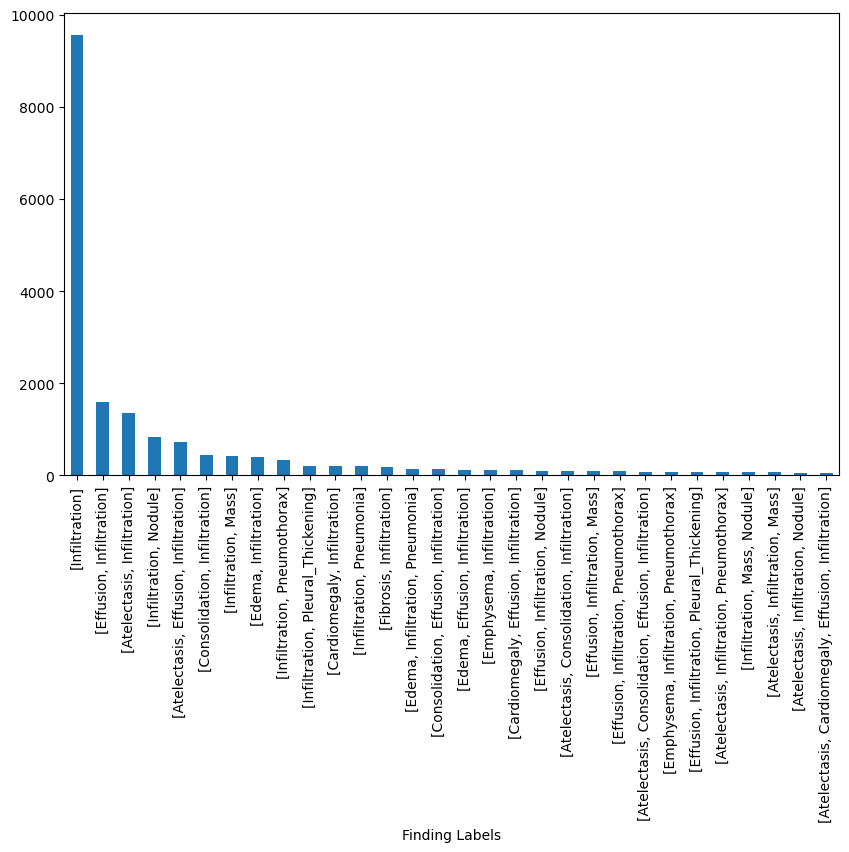

In [10]:
# Let's check Infiltration
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Infiltration==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar');

# Infiltration is most commonly shown in isolation, followed by having comorbidity with Effusion, then Atelectasis.
# But note that it is not primarily associated with Pneumonia.

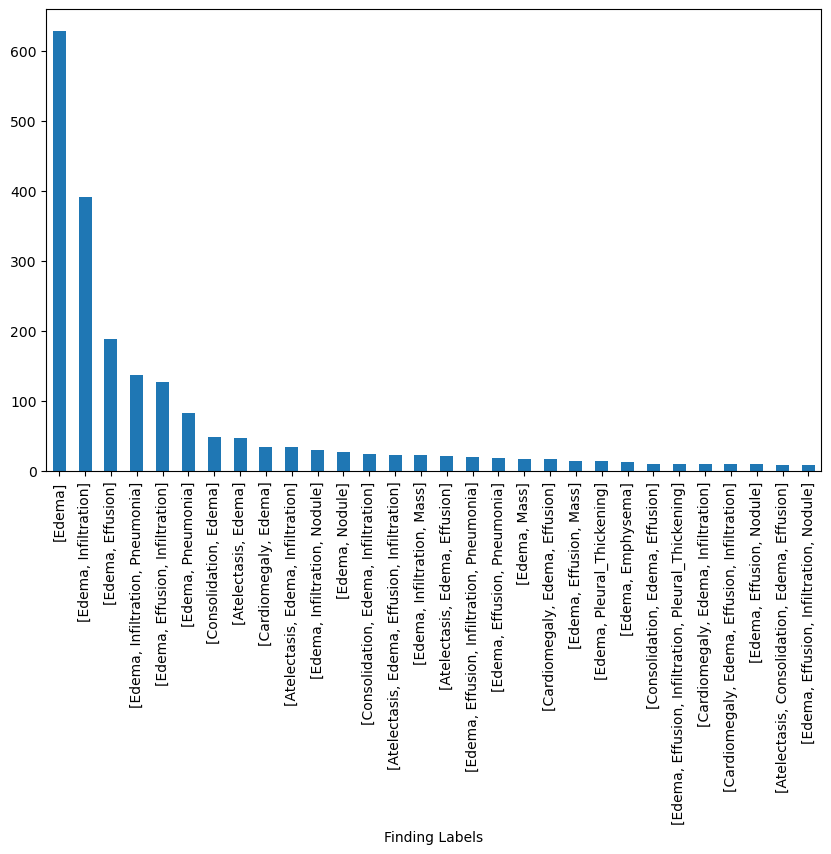

In [11]:
# Let's check Edema
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Edema==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar');

# Edema most commonly has comorbidity with:
# Infiltration
# Effusion
# Infiltration and Pneumonia

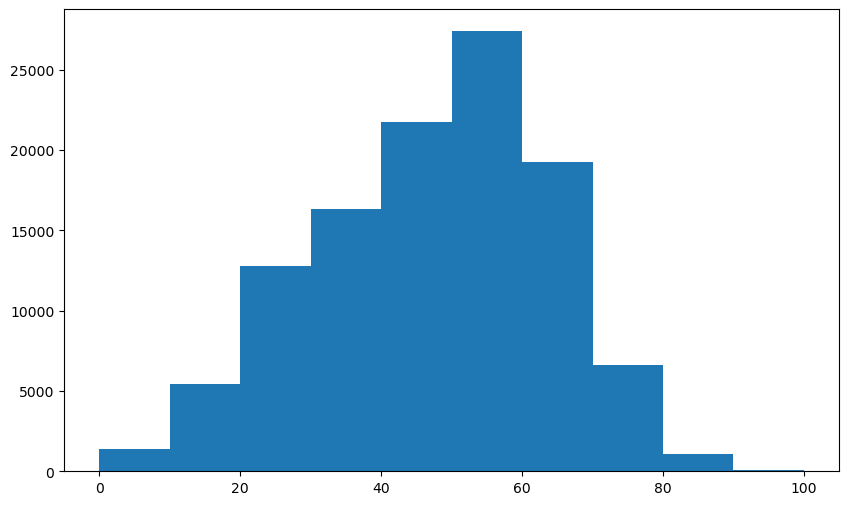

In [12]:
# 2. Create distributions of basic demographics of the patients who make up the dataset ("Patient Age", "Patient Gender", "View Position")
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins=10, range=(0,100));

Min age: 1
Max age: 414


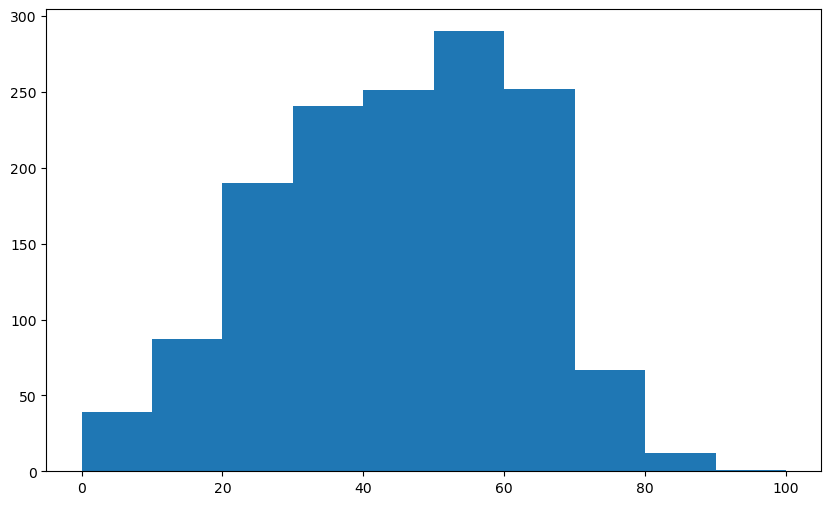

In [13]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=10, range=(0,100));

# Also get minimum and maximum ages for FDA submission
print(f"Min age: {all_xray_df['Patient Age'].min()}")
print(f"Max age: {all_xray_df['Patient Age'].max()}")

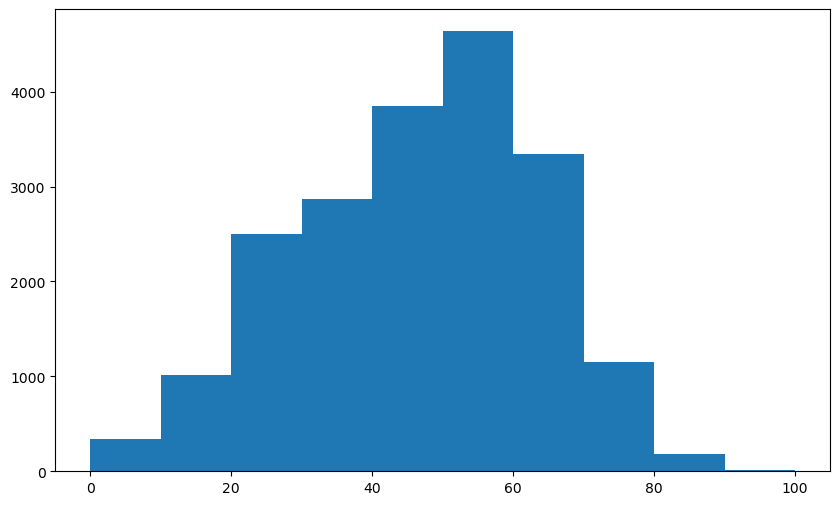

In [14]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Infiltration==1]['Patient Age'], bins=10, range=(0,100));

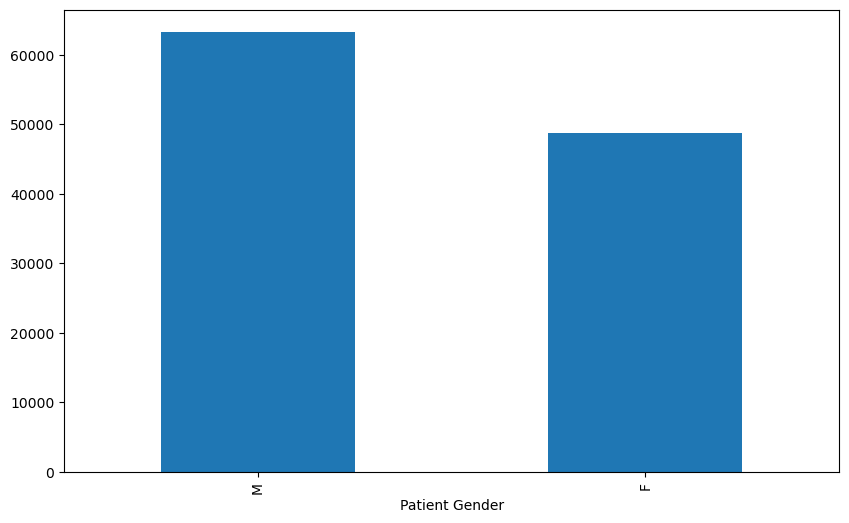

In [15]:
plt.figure(figsize=(10,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar');

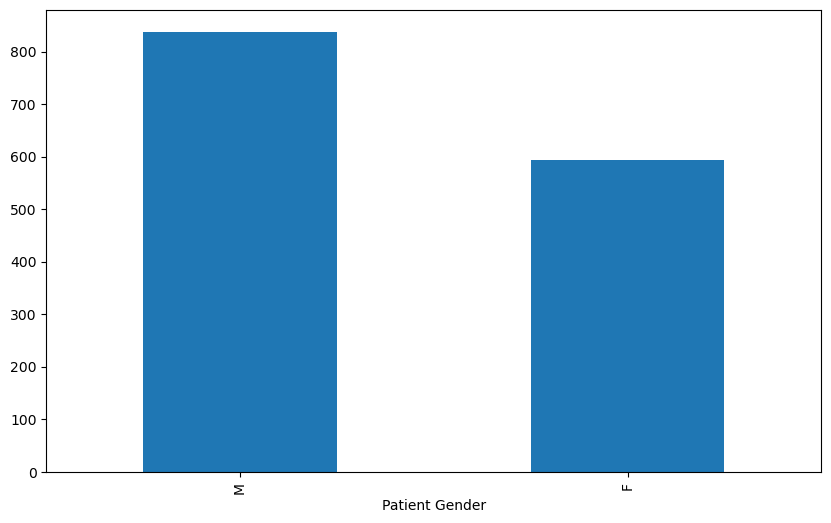

In [16]:
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar');

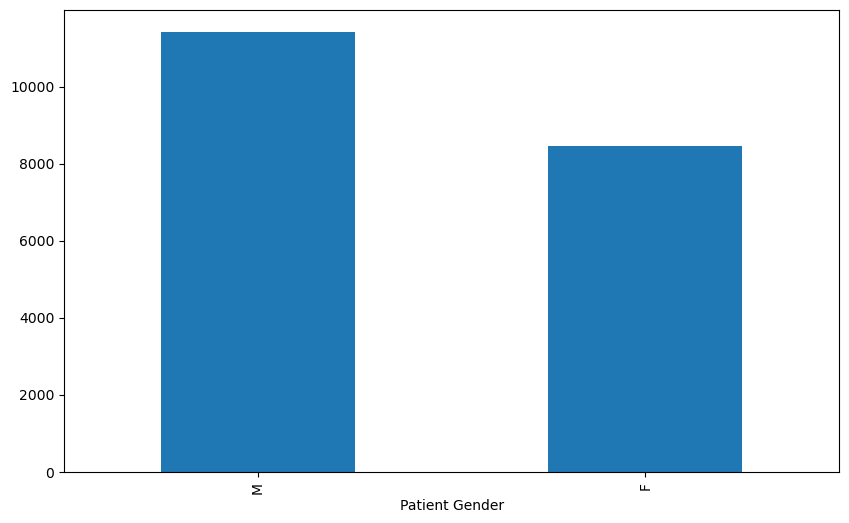

In [17]:
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Infiltration==1]['Patient Gender'].value_counts().plot(kind='bar');

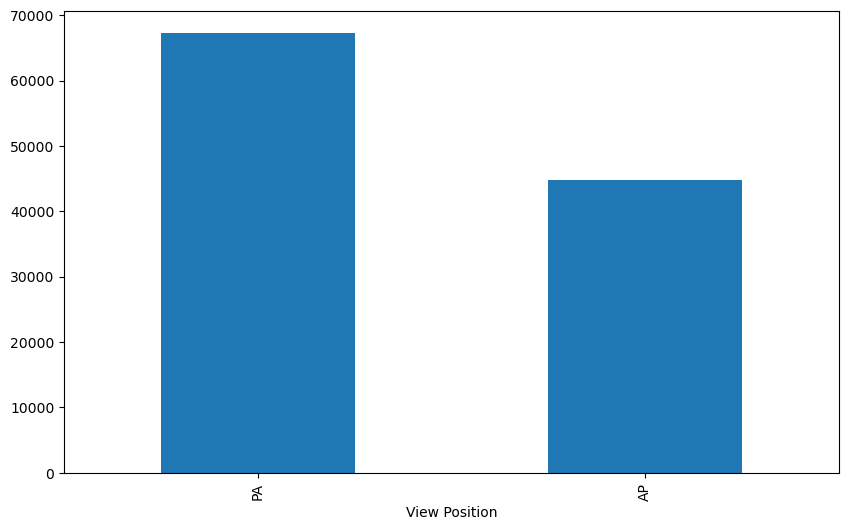

In [18]:
plt.figure(figsize=(10,6))
all_xray_df['View Position'].value_counts().plot(kind='bar');

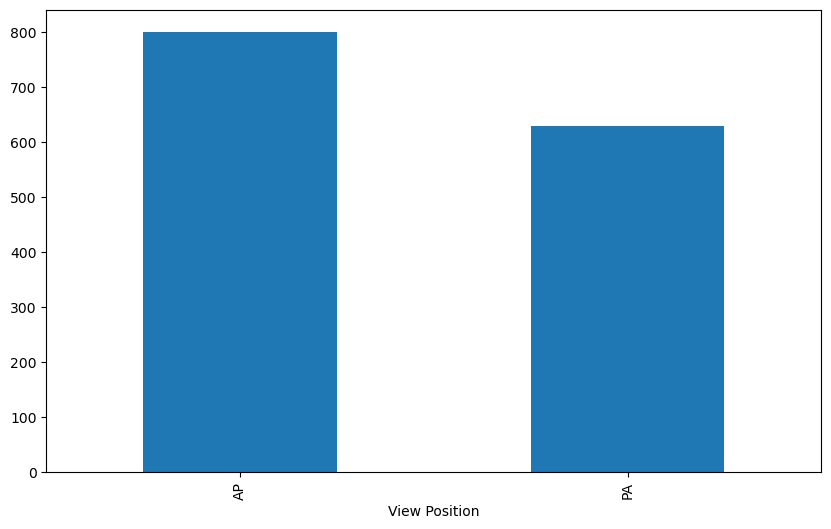

In [19]:
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar');

<Axes: xlabel='View Position'>

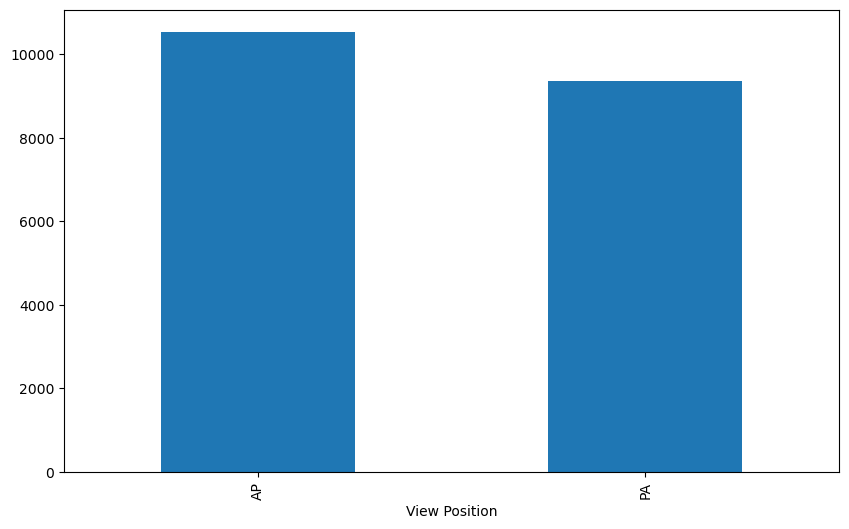

In [20]:
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Infiltration==1]['View Position'].value_counts().plot(kind='bar')

In [21]:
pneumonia = all_xray_df['Pneumonia'].values
pneumonia_inds = np.where(~np.isnan(pneumonia))
ages = all_xray_df.iloc[pneumonia_inds]['Patient Age']
pneumonia=pneumonia[pneumonia_inds]
scipy.stats.pearsonr(pneumonia,ages)

PearsonRResult(statistic=-0.01332929555091885, pvalue=8.06793868647919e-06)

In [22]:
genders = all_xray_df.iloc[pneumonia_inds]['Patient Gender'].map(lambda x: 0 if x=='M' else 1).values
scipy.stats.pearsonr(pneumonia,genders)

PearsonRResult(statistic=-0.004741503918075695, pvalue=0.11236510019278391)

In [23]:
positions = all_xray_df.iloc[pneumonia_inds]['View Position'].map(lambda x: 0 if x=='PA' else 1).values
scipy.stats.pearsonr(pneumonia,positions)

PearsonRResult(statistic=0.03716040367245752, pvalue=1.45073313521413e-35)

In [24]:
np.mean(all_xray_df[all_xray_df['Patient Gender']== 'M']['Pneumonia'])

0.01323018629617935

In [25]:
np.mean(all_xray_df[all_xray_df['Patient Gender']== 'F']['Pneumonia'])

0.012156621566215662

In [26]:
all_xray_df[all_xray_df['Patient Gender']== 'M'].size / all_xray_df.size

0.5649304316803425

In [27]:
all_xray_df[all_xray_df['Patient Gender']== 'F'].size / all_xray_df.size

0.4350695683196575

In [28]:
# Helper functions to find images with a specific condition.
# As pixel analysis data was requested to be taken from sample_labels.csv, this will be 
# checked first for valid bounding box data against the bounding box dataframe, and if
# not found, fall back to using the full dataset.
found_images = []
def find_image_with_condition(condition, bbox_df):
    image_name, image_path = find_image_with_condition_specific_df(data_sample, condition, bbox_df)
    if image_path is None:
        image_name, image_path = find_image_with_condition_specific_df(all_xray_df, condition, bbox_df, "FindingLabels_Original")
    if image_path is None:
        exit(1)
    return image_name, image_path
    
def find_image_with_condition_specific_df(df, condition, bbox_df, finding_col_name="Finding Labels"):
    for j in range(len(df[df[finding_col_name] == condition])):
        image = df[df[finding_col_name] == condition].iloc[j]
        image_name = image['Image Index']
        image_path = image['path']
        bbox = bbox_df[bbox_df['Image Index'] == image_name]
        if bbox.size > 0 and image_name not in found_images:
            print(f"{condition} Image name: {image_name}")
            found_images.append(image_name)
            return image_name, image_path
    
    return None, None

In [29]:
# Helper function to get the mean and standard deviation of pixel intensity values
def get_intensities(image, label):
    mean_intensity = np.mean(image.ravel())
    std_intensity = np.std(image.ravel())
    print(f"({label}) Mean intensity:", mean_intensity)
    print(f"({label}) Standard deviation intensity:", std_intensity)
    return mean_intensity, std_intensity

In [30]:
# Helper function to show an image
def show_image(image_path, display=True):
    img = mpimg.imread(image_path)
    if display:
        plt.imshow(img, cmap='gray')

    return img

In [31]:
# Helper function to plot a histogram of pixel intensity values
def plot_pixel_intensity_histogram(image, label, standardized=False):
    if standardized:
        mean_intensity, std_intensity = get_intensities(image, label)
        image = (image - mean_intensity) / std_intensity

    plt.figure(figsize=(5,5))
    plt.hist(image.ravel(), bins = 256, label = label)

In [32]:
# Helper function to plot a bounding box on an image
def show_image_with_bounding_box(image, bbox_df, image_name):
    bbox = bbox_df[bbox_df['Image Index'] == image_name]
    bbox_x = bbox['Bbox_x'].values[0]
    bbox_y = bbox['Bbox_y'].values[0]
    bbox_w = bbox['Bbox_w'].values[0]
    bbox_h = bbox['Bbox_h'].values[0]

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image, cmap='gray')
    
    # Create a bounding box
    x, y, width, height = bbox_x, bbox_y, bbox_w, bbox_h
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the bounding box to the axes
    ax.add_patch(rect)

    # Show the plot
    plt.show()

    return x, y, width, height

In [33]:
# Helper function to perform EDA on an image with a specific condition
def perform_xray_eda(condition, bbox_df):
    img_name, img_path = find_image_with_condition(condition, bbox_df)
    img = show_image(img_path, False)
    plot_pixel_intensity_histogram(img, f"{condition} Standardized", True)
    x, y, w, h = show_image_with_bounding_box(img, bbox_df, img_name)
    plot_pixel_intensity_histogram(img[int(y):int(y)+int(h), int(x):int(x)+int(w)], f"{condition} Standardized Bounding Box", True)

Pneumonia Image name: 00000193_019.png
(Pneumonia Standardized) Mean intensity: 0.5960483
(Pneumonia Standardized) Standard deviation intensity: 0.22227651


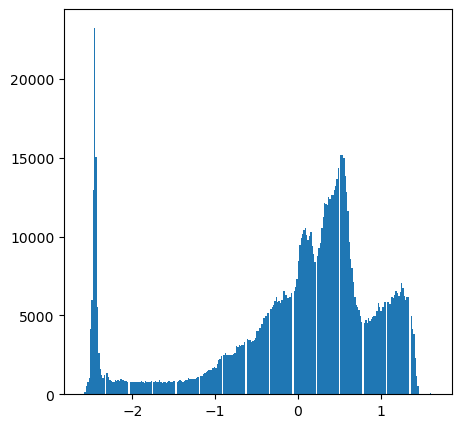

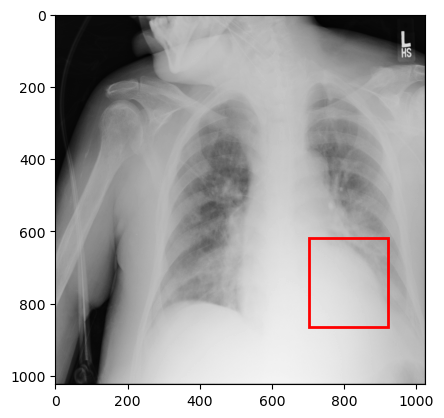

(Pneumonia Standardized Bounding Box) Mean intensity: 0.7757203
(Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.07079135


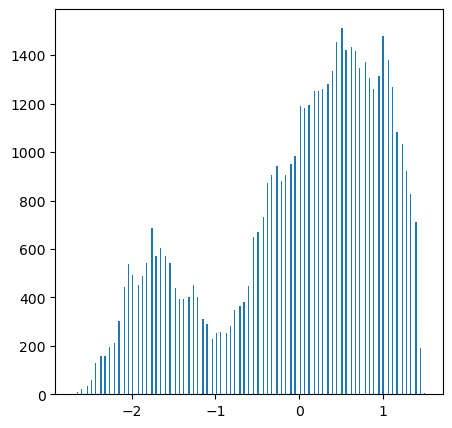

In [34]:
perform_xray_eda("Pneumonia", bbox_df)

Pneumonia Image name: 00004344_002.png
(Pneumonia Standardized) Mean intensity: 0.57270634
(Pneumonia Standardized) Standard deviation intensity: 0.24761112


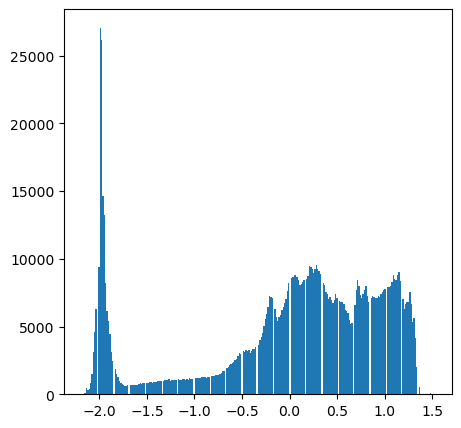

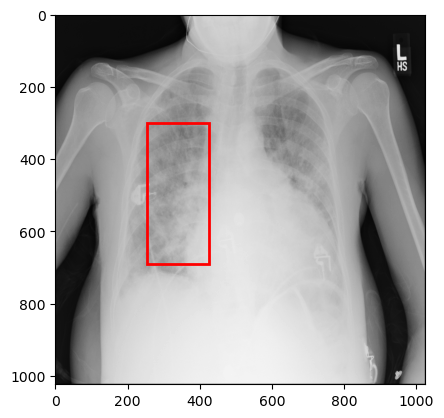

(Pneumonia Standardized Bounding Box) Mean intensity: 0.6359753
(Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.08069229


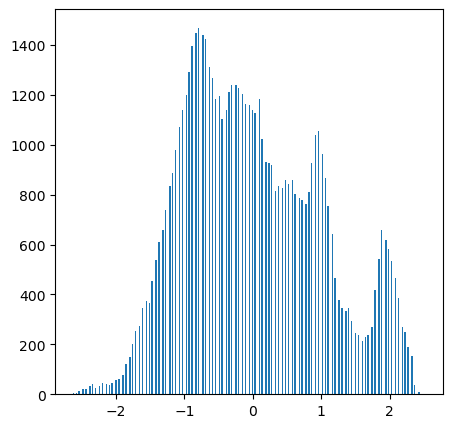

In [35]:
perform_xray_eda("Pneumonia", bbox_df)

Pneumonia Image name: 00004893_070.png
(Pneumonia Standardized) Mean intensity: 0.4431391
(Pneumonia Standardized) Standard deviation intensity: 0.2354922


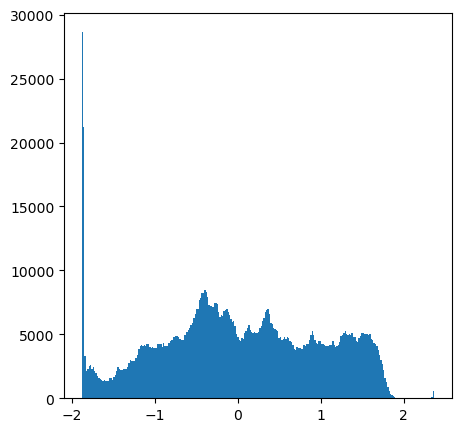

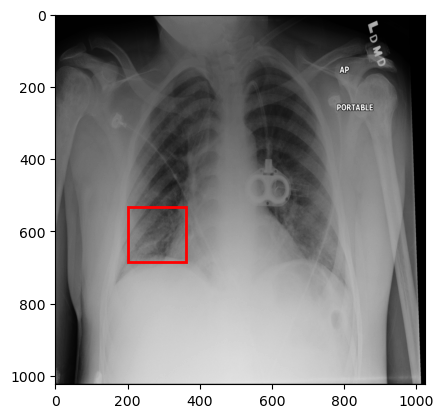

(Pneumonia Standardized Bounding Box) Mean intensity: 0.40522397
(Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.09447273


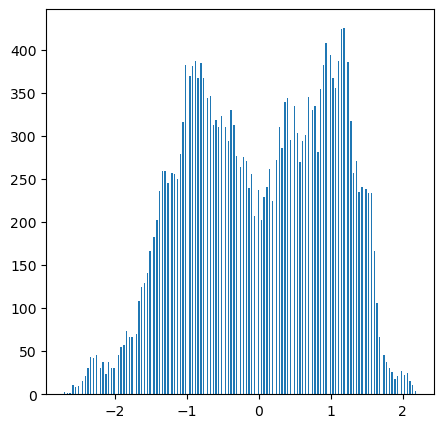

In [36]:
perform_xray_eda("Pneumonia", bbox_df)

Pneumonia Image name: 00005567_025.png
(Pneumonia Standardized) Mean intensity: 0.48415217
(Pneumonia Standardized) Standard deviation intensity: 0.2625533


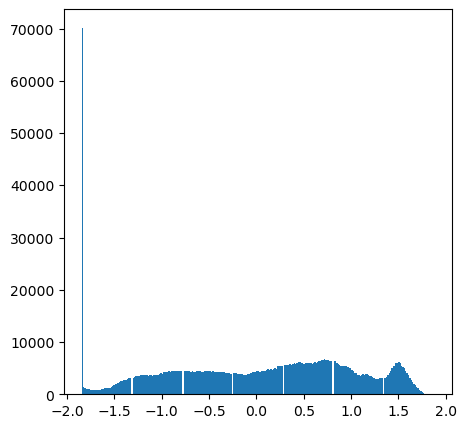

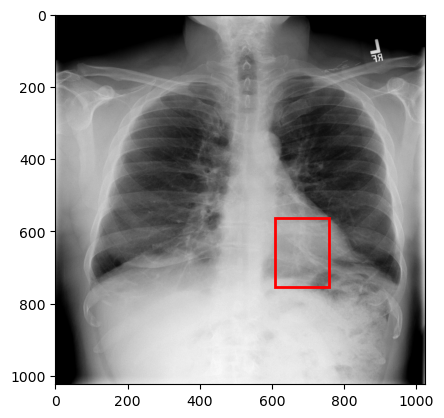

(Pneumonia Standardized Bounding Box) Mean intensity: 0.6102493
(Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.06806408


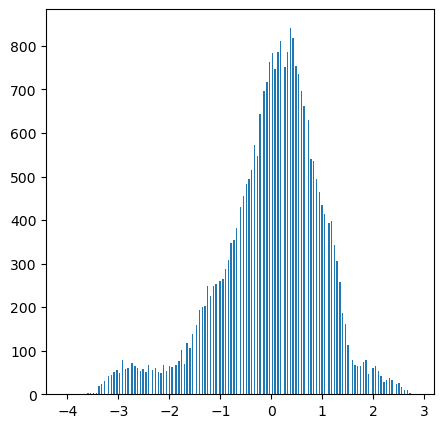

In [37]:
perform_xray_eda("Pneumonia", bbox_df)

Pneumonia Image name: 00007444_003.png
(Pneumonia Standardized) Mean intensity: 0.6719434
(Pneumonia Standardized) Standard deviation intensity: 0.2279788


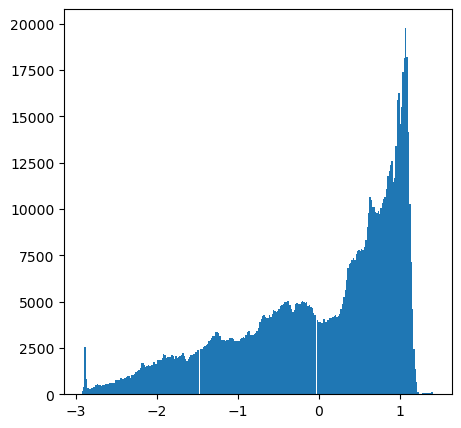

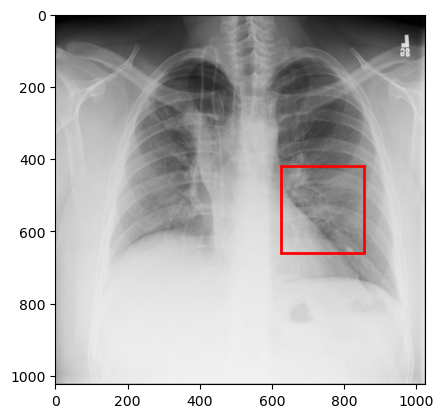

(Pneumonia Standardized Bounding Box) Mean intensity: 0.5827615
(Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.098989


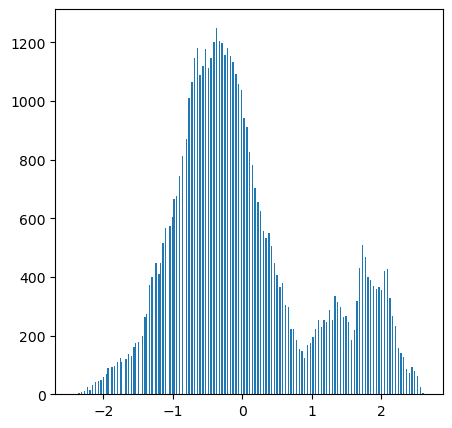

In [38]:
perform_xray_eda("Pneumonia", bbox_df)

Edema|Infiltration|Pneumonia Image name: 00004808_090.png
(Edema|Infiltration|Pneumonia Standardized) Mean intensity: 0.46054488
(Edema|Infiltration|Pneumonia Standardized) Standard deviation intensity: 0.19296712


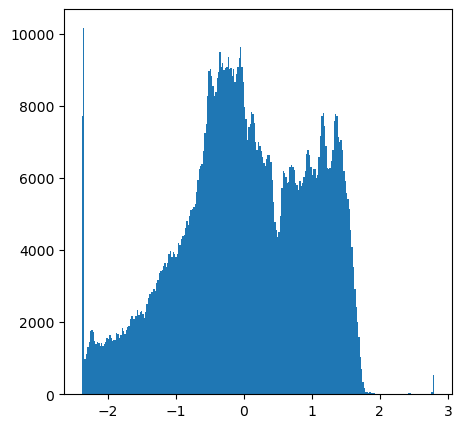

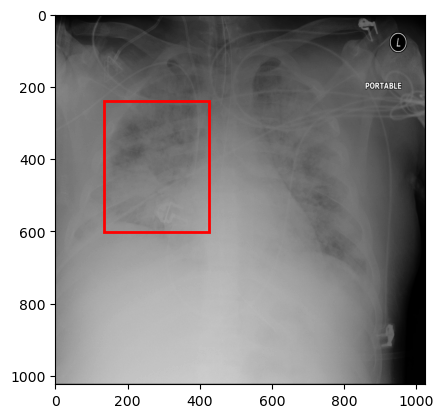

(Edema|Infiltration|Pneumonia Standardized Bounding Box) Mean intensity: 0.47715595
(Edema|Infiltration|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.07433439


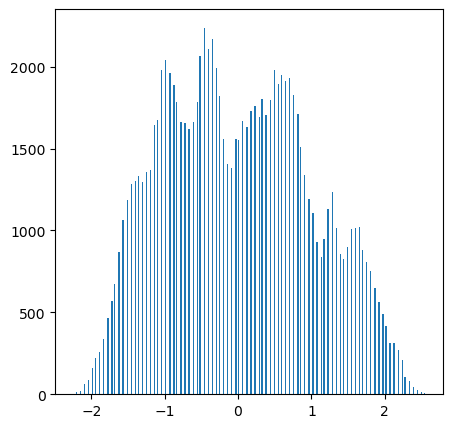

In [39]:
perform_xray_eda("Edema|Infiltration|Pneumonia", bbox_df)

Edema|Infiltration|Pneumonia Image name: 00013993_013.png
(Edema|Infiltration|Pneumonia Standardized) Mean intensity: 0.43198225
(Edema|Infiltration|Pneumonia Standardized) Standard deviation intensity: 0.20036845


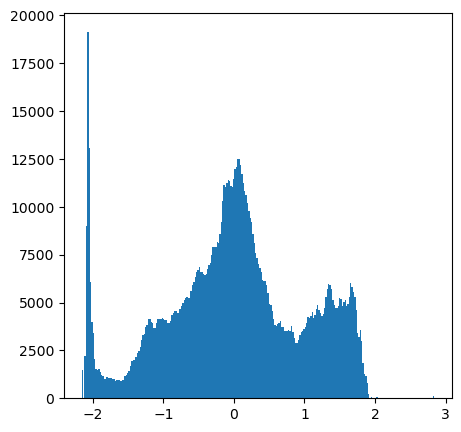

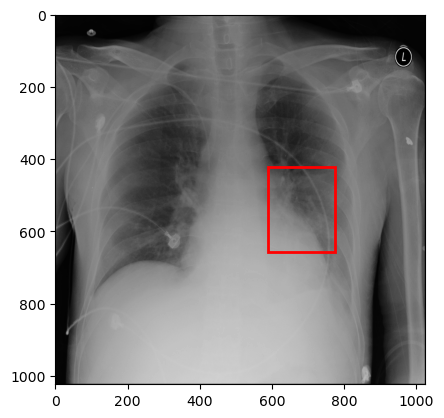

(Edema|Infiltration|Pneumonia Standardized Bounding Box) Mean intensity: 0.42567098
(Edema|Infiltration|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.11457627


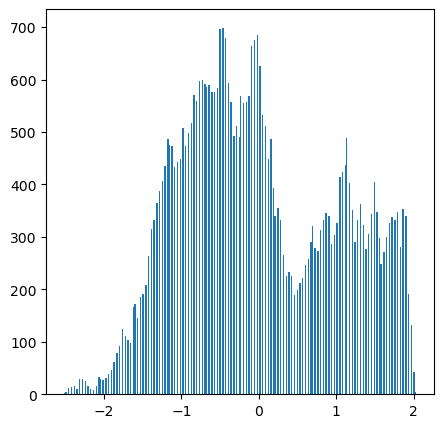

In [40]:
perform_xray_eda("Edema|Infiltration|Pneumonia", bbox_df)

Pneumonia Image name: 00007735_018.png
(Pneumonia Standardized) Mean intensity: 0.45564607
(Pneumonia Standardized) Standard deviation intensity: 0.20659068


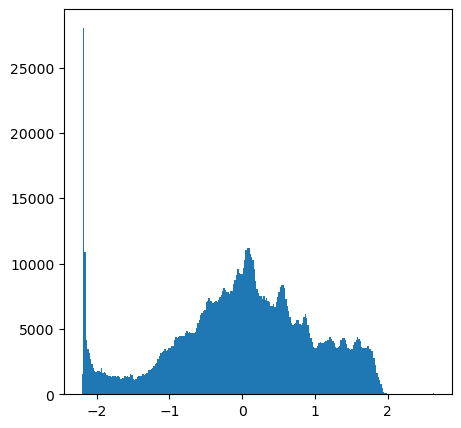

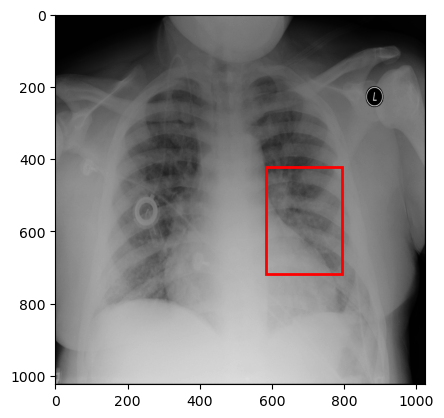

(Pneumonia Standardized Bounding Box) Mean intensity: 0.45102364
(Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.101612784


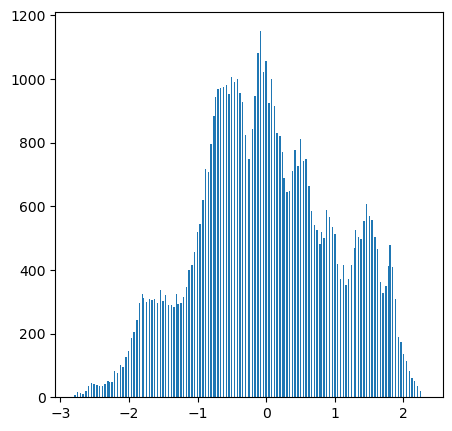

In [41]:
perform_xray_eda("Pneumonia", bbox_df)

Edema|Infiltration|Pneumonia Image name: 00028454_016.png
(Edema|Infiltration|Pneumonia Standardized) Mean intensity: 0.409322
(Edema|Infiltration|Pneumonia Standardized) Standard deviation intensity: 0.2364206


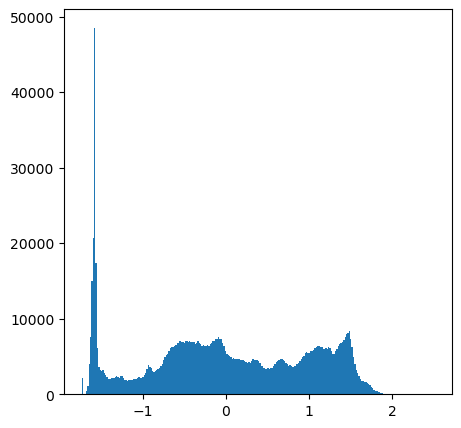

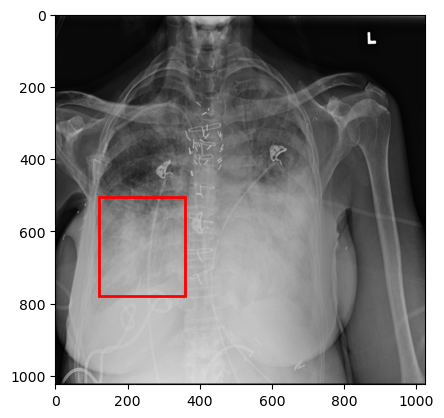

(Edema|Infiltration|Pneumonia Standardized Bounding Box) Mean intensity: 0.6060133
(Edema|Infiltration|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.09235562


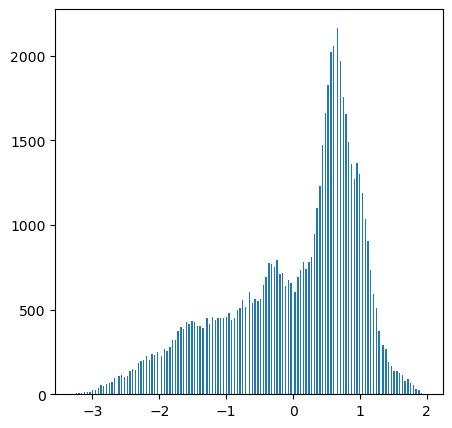

In [42]:
perform_xray_eda("Edema|Infiltration|Pneumonia", bbox_df)

Infiltration|Pneumonia Image name: 00016786_001.png
(Infiltration|Pneumonia Standardized) Mean intensity: 0.44518438
(Infiltration|Pneumonia Standardized) Standard deviation intensity: 0.19916663


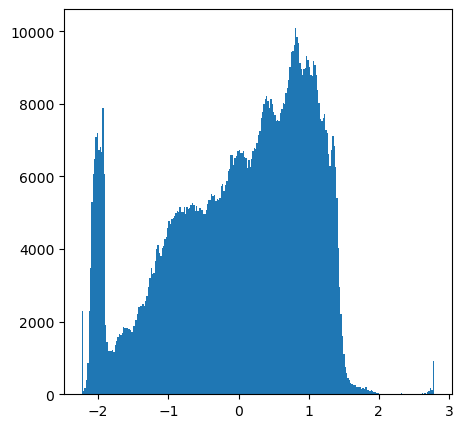

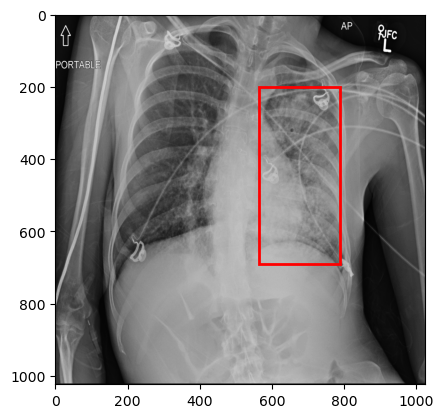

(Infiltration|Pneumonia Standardized Bounding Box) Mean intensity: 0.5563837
(Infiltration|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.10255389


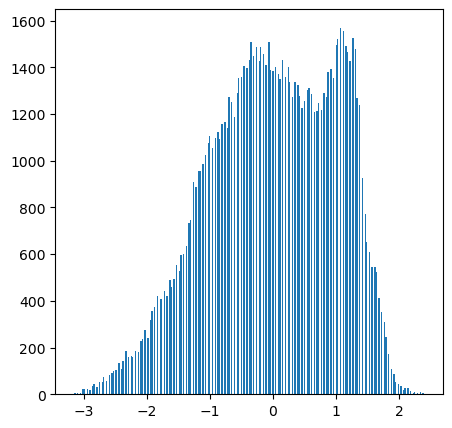

In [43]:
perform_xray_eda("Infiltration|Pneumonia", bbox_df)

Infiltration|Pneumonia Image name: 00023089_004.png
(Infiltration|Pneumonia Standardized) Mean intensity: 0.48714173
(Infiltration|Pneumonia Standardized) Standard deviation intensity: 0.27720994


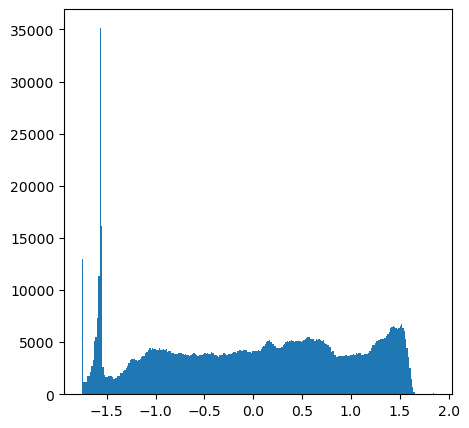

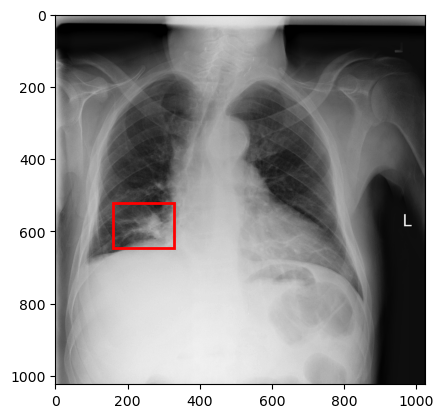

(Infiltration|Pneumonia Standardized Bounding Box) Mean intensity: 0.38974136
(Infiltration|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.16407967


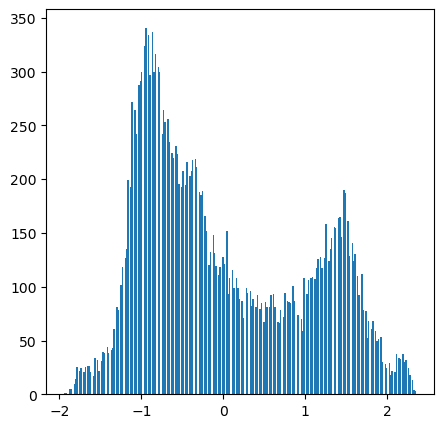

In [44]:
perform_xray_eda("Infiltration|Pneumonia", bbox_df)

Infiltration|Pneumonia Image name: 00002711_000.png
(Infiltration|Pneumonia Standardized) Mean intensity: 0.37603256
(Infiltration|Pneumonia Standardized) Standard deviation intensity: 0.24480604


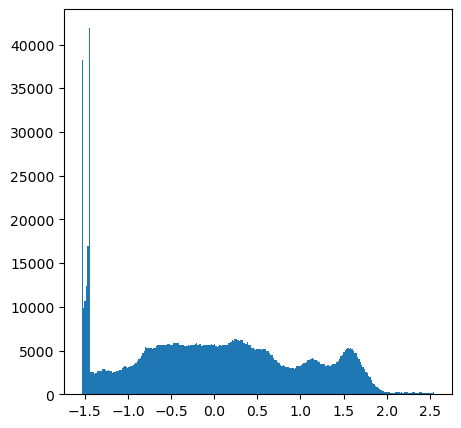

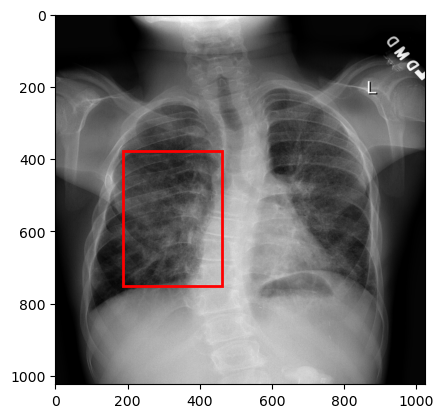

(Infiltration|Pneumonia Standardized Bounding Box) Mean intensity: 0.3385118
(Infiltration|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.17065157


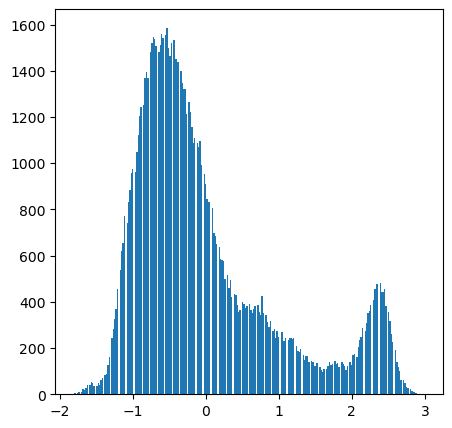

In [45]:
perform_xray_eda("Infiltration|Pneumonia", bbox_df)

Atelectasis|Pneumonia Image name: 00003528_024.png
(Atelectasis|Pneumonia Standardized) Mean intensity: 0.4405222
(Atelectasis|Pneumonia Standardized) Standard deviation intensity: 0.20869178


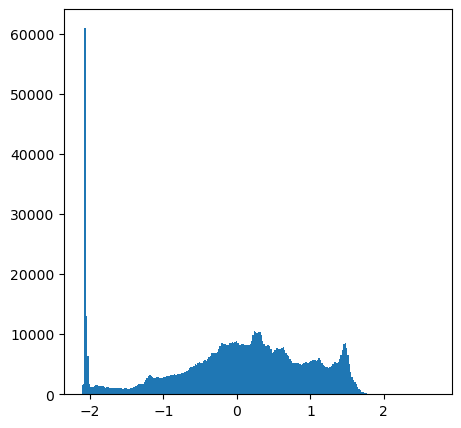

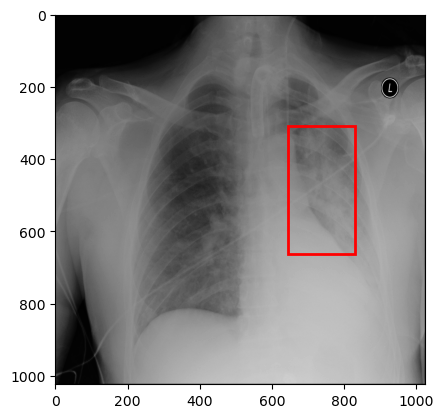

(Atelectasis|Pneumonia Standardized Bounding Box) Mean intensity: 0.5229309
(Atelectasis|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.08963362


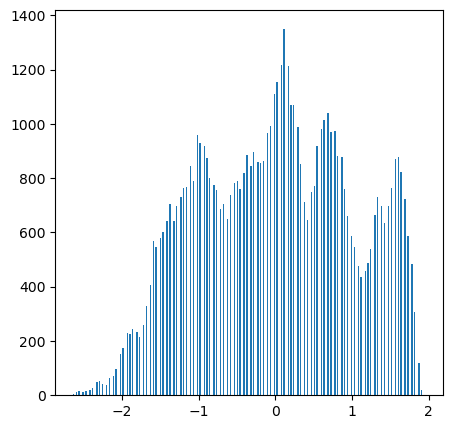

In [46]:
perform_xray_eda("Atelectasis|Pneumonia", bbox_df)

Atelectasis|Pneumonia Image name: 00007629_001.png
(Atelectasis|Pneumonia Standardized) Mean intensity: 0.691685
(Atelectasis|Pneumonia Standardized) Standard deviation intensity: 0.1596138


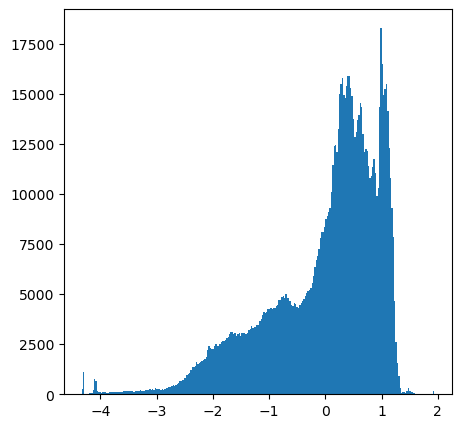

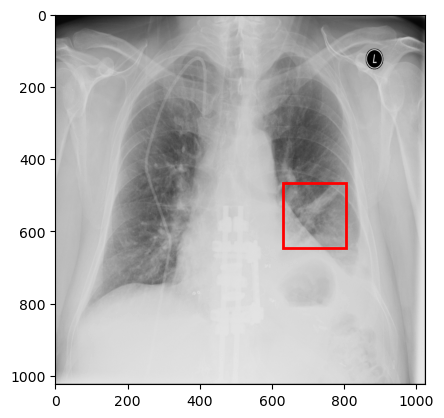

(Atelectasis|Pneumonia Standardized Bounding Box) Mean intensity: 0.5836485
(Atelectasis|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.10565704


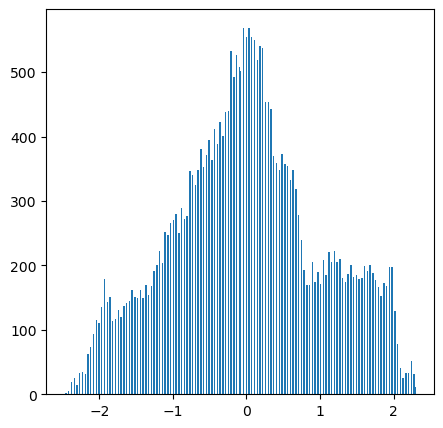

In [47]:
perform_xray_eda("Atelectasis|Pneumonia", bbox_df)

Atelectasis|Pneumonia Image name: 00010652_000.png
(Atelectasis|Pneumonia Standardized) Mean intensity: 0.5431478
(Atelectasis|Pneumonia Standardized) Standard deviation intensity: 0.30310476


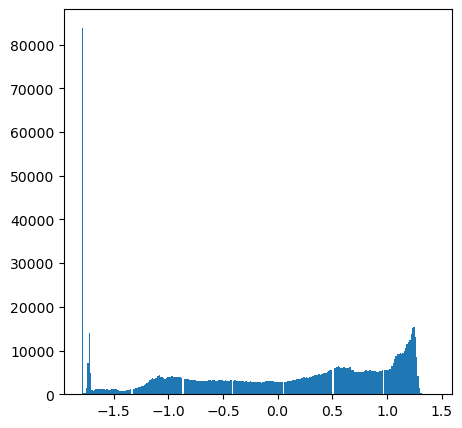

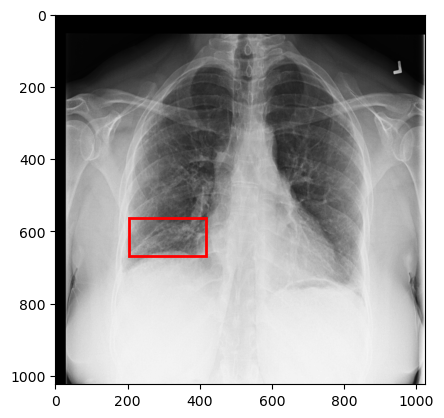

(Atelectasis|Pneumonia Standardized Bounding Box) Mean intensity: 0.47860757
(Atelectasis|Pneumonia Standardized Bounding Box) Standard deviation intensity: 0.110886544


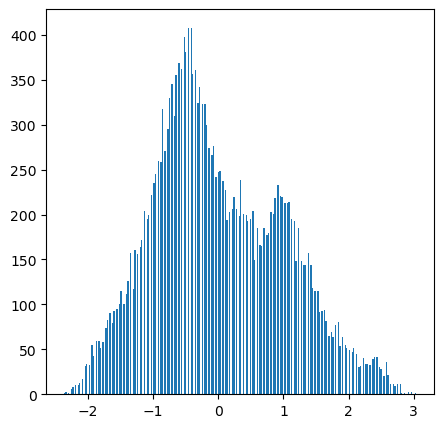

In [48]:
perform_xray_eda("Atelectasis|Pneumonia", bbox_df)

Infiltration Image name: 00000468_041.png
(Infiltration Standardized) Mean intensity: 0.3460822
(Infiltration Standardized) Standard deviation intensity: 0.2887052


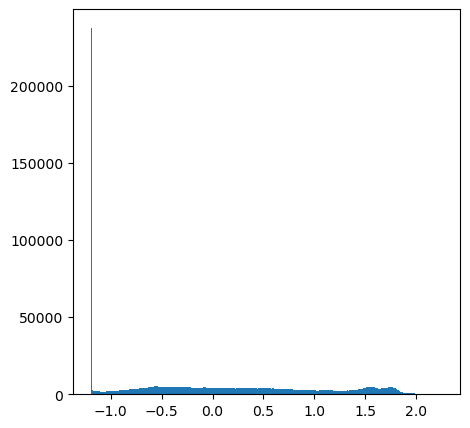

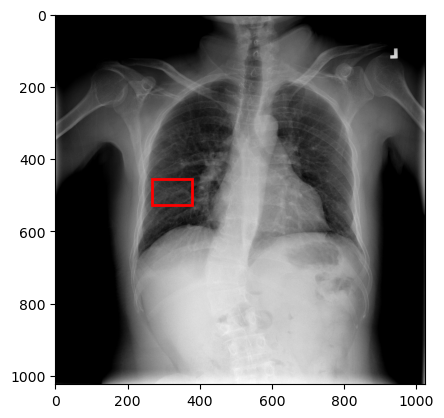

(Infiltration Standardized Bounding Box) Mean intensity: 0.21689427
(Infiltration Standardized Bounding Box) Standard deviation intensity: 0.047459234


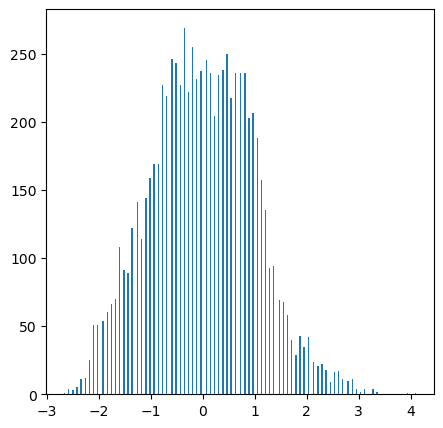

In [49]:
perform_xray_eda("Infiltration", bbox_df)

Infiltration Image name: 00002224_007.png
(Infiltration Standardized) Mean intensity: 0.5354848
(Infiltration Standardized) Standard deviation intensity: 0.24711543


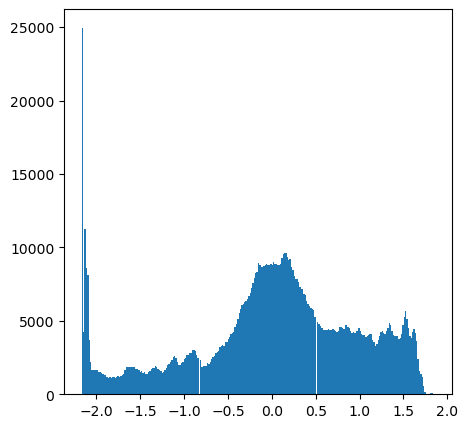

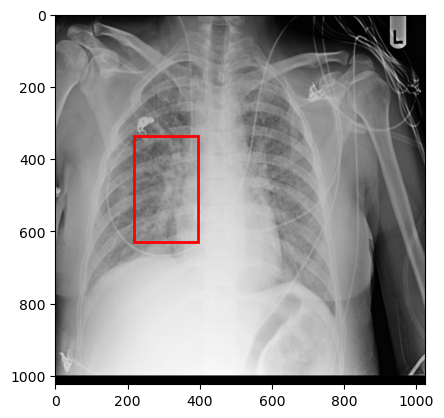

(Infiltration Standardized Bounding Box) Mean intensity: 0.5576198
(Infiltration Standardized Bounding Box) Standard deviation intensity: 0.10207969


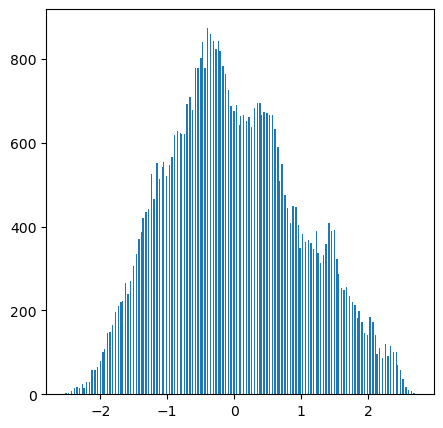

In [50]:
perform_xray_eda("Infiltration", bbox_df)

Infiltration Image name: 00010230_001.png
(Infiltration Standardized) Mean intensity: 0.43118784
(Infiltration Standardized) Standard deviation intensity: 0.307429


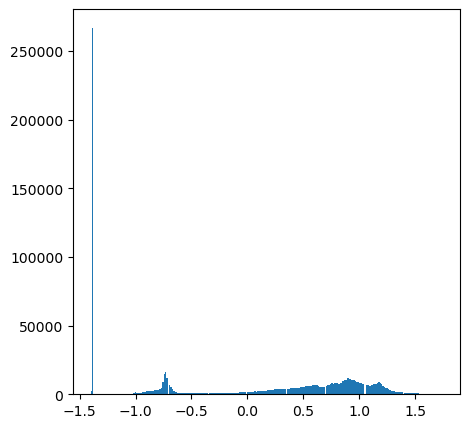

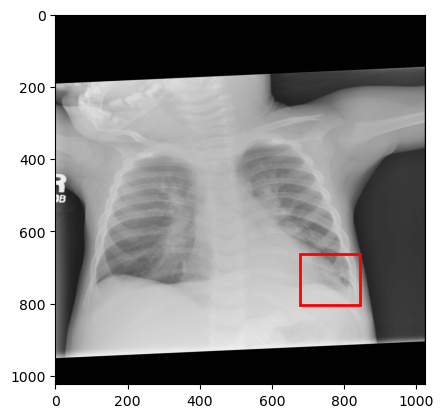

(Infiltration Standardized Bounding Box) Mean intensity: 0.6946717
(Infiltration Standardized Bounding Box) Standard deviation intensity: 0.08669067


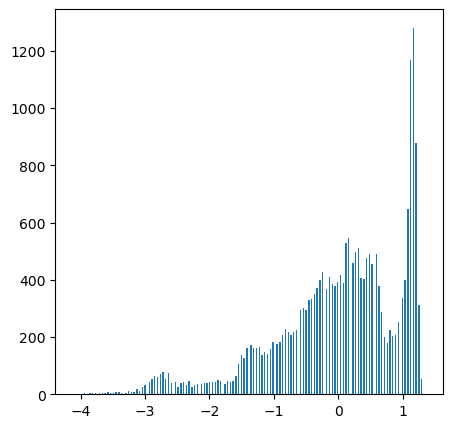

In [51]:
perform_xray_eda("Infiltration", bbox_df)

**Conclusions**
- The dataset is imbalanced, with the most common label being "No Finding" (53.8% of the dataset).
- Pneumonia most often has comorbidity with Infiltration, followed by Infiltration and Edema, Atelectasis, and Edema.
- Infiltration is most commonly shown in isolation, followed by having comorbidity with Effusion, then Atelectasis.
- Edema most commonly has comorbidity with Infiltration, Effusion, and Infiltration and Pneumonia.
- The dataset is not primarily associated with Pneumonia, as only 1.3% of the dataset has this label.
- The age distribution of the dataset follows a fairly normal distribution with a bit of a right skew, peaking around age 55.
- The age distribution of patients with Pneumonia is similar to the overall age distribution.
- There are more male patients (56.4%) in this dataset than female (43.6%).
- The distributions of patient age, view position, Pneumonia, and Infiltration follow a similar pattern for the distribution of gender.
- There is no significant correlation between age and Pneumonia.
- There is no significant correlation between gender and Pneumonia.
- The model training will be set up to handle the imbalanced dataset, so we should use a distribution of 50% Pneumonia and 50% No Pneumonia.
- It is not easy to differentiate between pixel intensities of Pneumonia in isolation and Pneumonia with comorbidites, so in the training set, we should treat all images with Pneumonia as positive, and all others as negative.
- The model training should be set up to handle a normal distribution of patient age.
- Though there is no significant correlation between gender and Pneumonia, the model training should be set up as an equal distribution to ensure that the model is not biased towards one gender.
- The model training should be set up to handle an equal distribution of view position to ensure that the model is not biased towards one view position.
- Based on the image data and pixel analysis, the model training split chosen above should be effective in training the model to detect Pneumonia.